In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/class-4/6aabc41571685772272b12bbc5fcdd64.jpg
/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/class-4/ea5917771ec3e717eae961f0f1b1cad0.jpg
/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/class-4/6ad5abeee40492d5bff1a102b0f47e66.jpg
/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/class-4/aa899bd84902e64c33d1a45030ae5c9e.jpg
/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/class-4/0cd252c938f2a09ae845a4d73f2f0508.jpg
/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/class-4/7057a25e6a6ee33c6d8f81dd507bea7c.jpg
/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/class-4/a36aaacc268d552c4c650a8579b0669a.jpg
/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/class-4/b689c7813074f2929c78153d82d96ed6.jpg
/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/c

In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.multiclass import unique_labels

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    plt.xticks(rotation=45)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()


In [4]:
# Function to show sample images
def show_sample_images(dataX, dataY, class_names):
    num_classes = len(class_names)
    for i in range(num_classes):
        class_indices = np.where(dataY == i)[0]
        sample_indices = random.sample(list(class_indices), 5)
        plt.figure(figsize=(15, 3))
        for j, idx in enumerate(sample_indices):
            plt.subplot(1, 5, j + 1)
            plt.imshow(dataX[idx])
            plt.title(class_names[i])
            plt.axis('off')
        plt.show()

In [5]:
# dataset path
data_dir = '../input/preprocessed-snake-images/preprocessed-cleaned-set/train/'
class_names = os.listdir(data_dir)

dataX = []
dataY = []

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    for image_name in tqdm(os.listdir(class_path)):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        if type(image) == np.ndarray:
            image = cv2.resize(image, dsize=(224, 224))
            dataX.append(image)
            dataY.append(class_name)

# Convert labels to numeric form
label_mapping = {class_name: i for i, class_name in enumerate(class_names)}
dataY = np.array([label_mapping[label] for label in dataY])

m = len(dataX)
M = list(range(m))
random.seed(2021)
random.shuffle(M)

dataX = np.array(dataX)
dataY = np.array(dataY)

trainX = dataX[M[0:(m//4)*3]]
trainY = dataY[M[0:(m//4)*3]]

testX = dataX[M[(m//4)*3:]]
testY = dataY[M[(m//4)*3:]]

trainx, testx, trainy, testy = train_test_split(trainX, trainY, test_size=0.2, random_state=44)


100%|██████████| 3547/3547 [00:23<00:00, 148.18it/s]


In [6]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
# Use Xception as the base model with fine-tuning
base_model = Xception(include_top=False, input_shape=(224, 224, 3))

# Fine-tune more layers
for layer in base_model.layers[:-20]:  # Fine-tune more layers
    layer.trainable = True

# the Dense layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# the learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)


83683744/83683744 [==============================] - 4s 0us/step


In [8]:
# the number of epochs
his = model.fit(datagen.flow(trainx, trainy, batch_size=32), validation_data=(testx, testy), epochs=350, callbacks=[early_stopping])

Epoch 1/350
326/326 [==============================] - 150s 347ms/step - loss: 0.9183 - accuracy: 0.6381 - val_loss: 0.5574 - val_accuracy: 0.8026
Epoch 2/350
326/326 [==============================] - 112s 341ms/step - loss: 0.4750 - accuracy: 0.8356 - val_loss: 0.3701 - val_accuracy: 0.8739
Epoch 3/350
326/326 [==============================] - 113s 345ms/step - loss: 0.3549 - accuracy: 0.8774 - val_loss: 0.3503 - val_accuracy: 0.8789
Epoch 4/350
326/326 [==============================] - 111s 339ms/step - loss: 0.2829 - accuracy: 0.9051 - val_loss: 0.4171 - val_accuracy: 0.8639
Epoch 5/350
326/326 [==============================] - 111s 339ms/step - loss: 0.2381 - accuracy: 0.9200 - val_loss: 0.3284 - val_accuracy: 0.8961
Epoch 6/350
326/326 [==============================] - 111s 339ms/step - loss: 0.1990 - accuracy: 0.9364 - val_loss: 0.3605 - val_accuracy: 0.8946
Epoch 7/350
326/326 [==============================] - 112s 341ms/step - loss: 0.1738 - accuracy: 0.9440 - val_loss: 0

In [9]:
# Evaluate the model
y_pred = model.predict(testx)
pred = np.argmax(y_pred, axis=1)

print(classification_report(testy, pred))
accuracy = accuracy_score(testy, pred)
print("Accuracy:", accuracy)

82/82 [==============================] - 6s 68ms/step
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       509
           1       0.96      0.96      0.96       590
           2       0.87      0.94      0.90       528
           3       0.85      0.83      0.84       471
           4       0.98      0.88      0.92       511

    accuracy                           0.90      2609
   macro avg       0.90      0.89      0.89      2609
weighted avg       0.90      0.90      0.90      2609

Accuracy: 0.8961287849750862


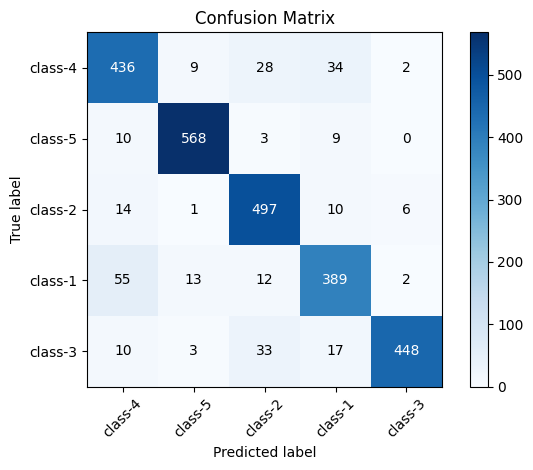

In [10]:
# Confusion Matrix
plot_confusion_matrix(testy, pred, class_names)

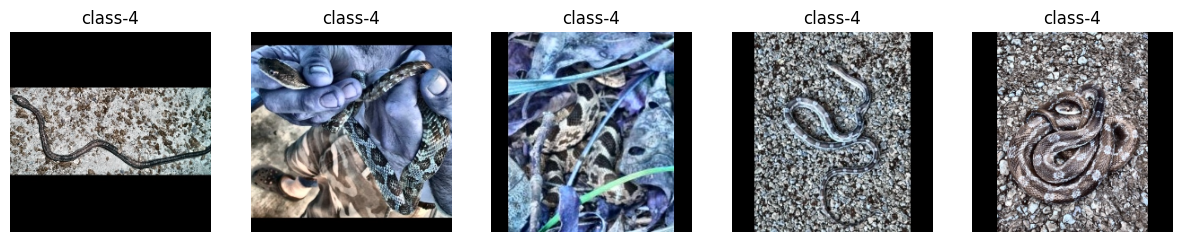

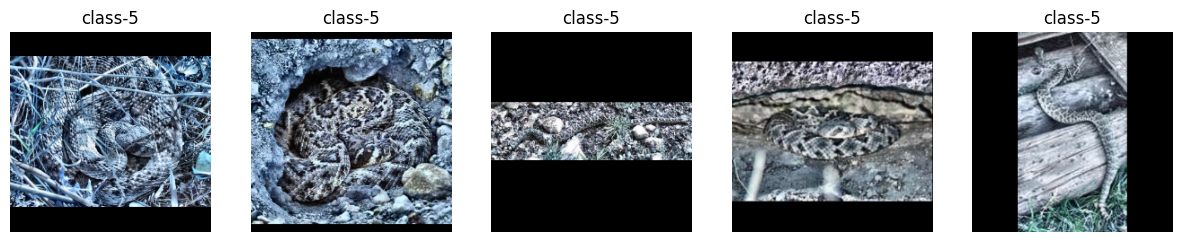

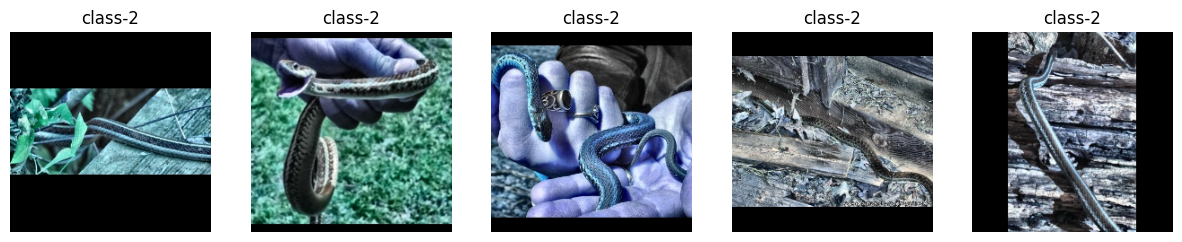

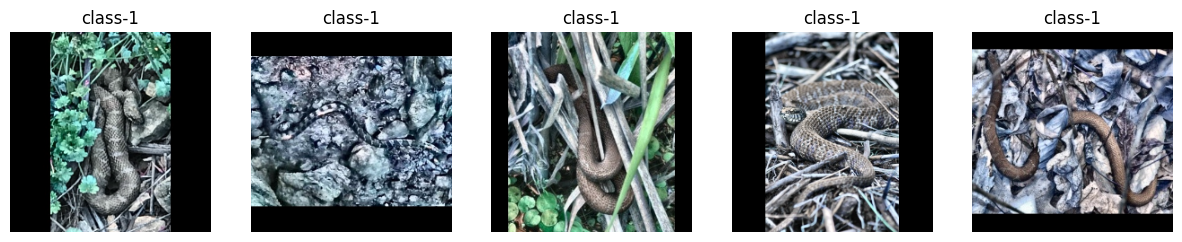

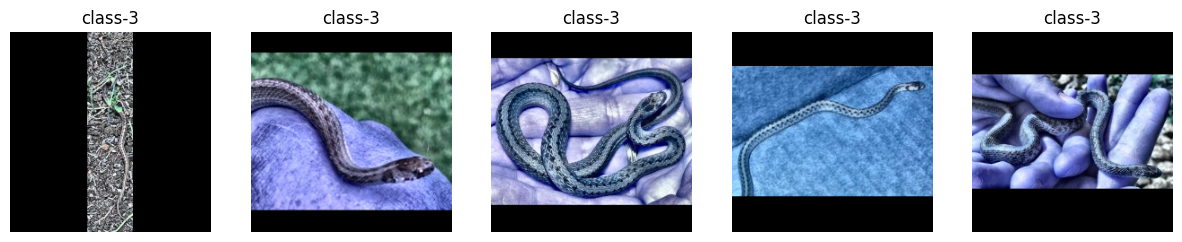

In [11]:
# Show sample images
show_sample_images(dataX, dataY, class_names)

<Figure size 640x480 with 0 Axes>

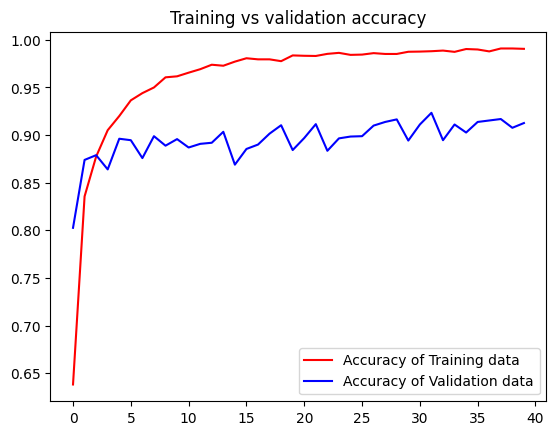

<Figure size 640x480 with 0 Axes>

In [12]:
# Plot training and validation accuracy
epochs = range(len(his.history['accuracy']))
plt.plot(epochs, his.history['accuracy'], 'r', label='Accuracy of Training data')
plt.plot(epochs, his.history['val_accuracy'], 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()

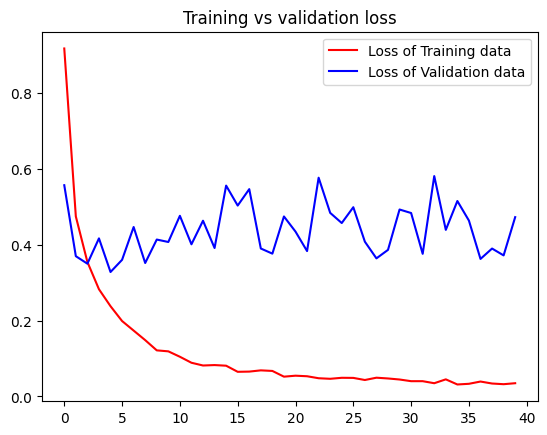

<Figure size 640x480 with 0 Axes>

In [13]:
# Plot training and validation loss
epochs = range(len(his.history['loss']))
plt.plot(epochs, his.history['loss'], 'r', label='Loss of Training data')
plt.plot(epochs, his.history['val_loss'], 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()